In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *

# Align IMU

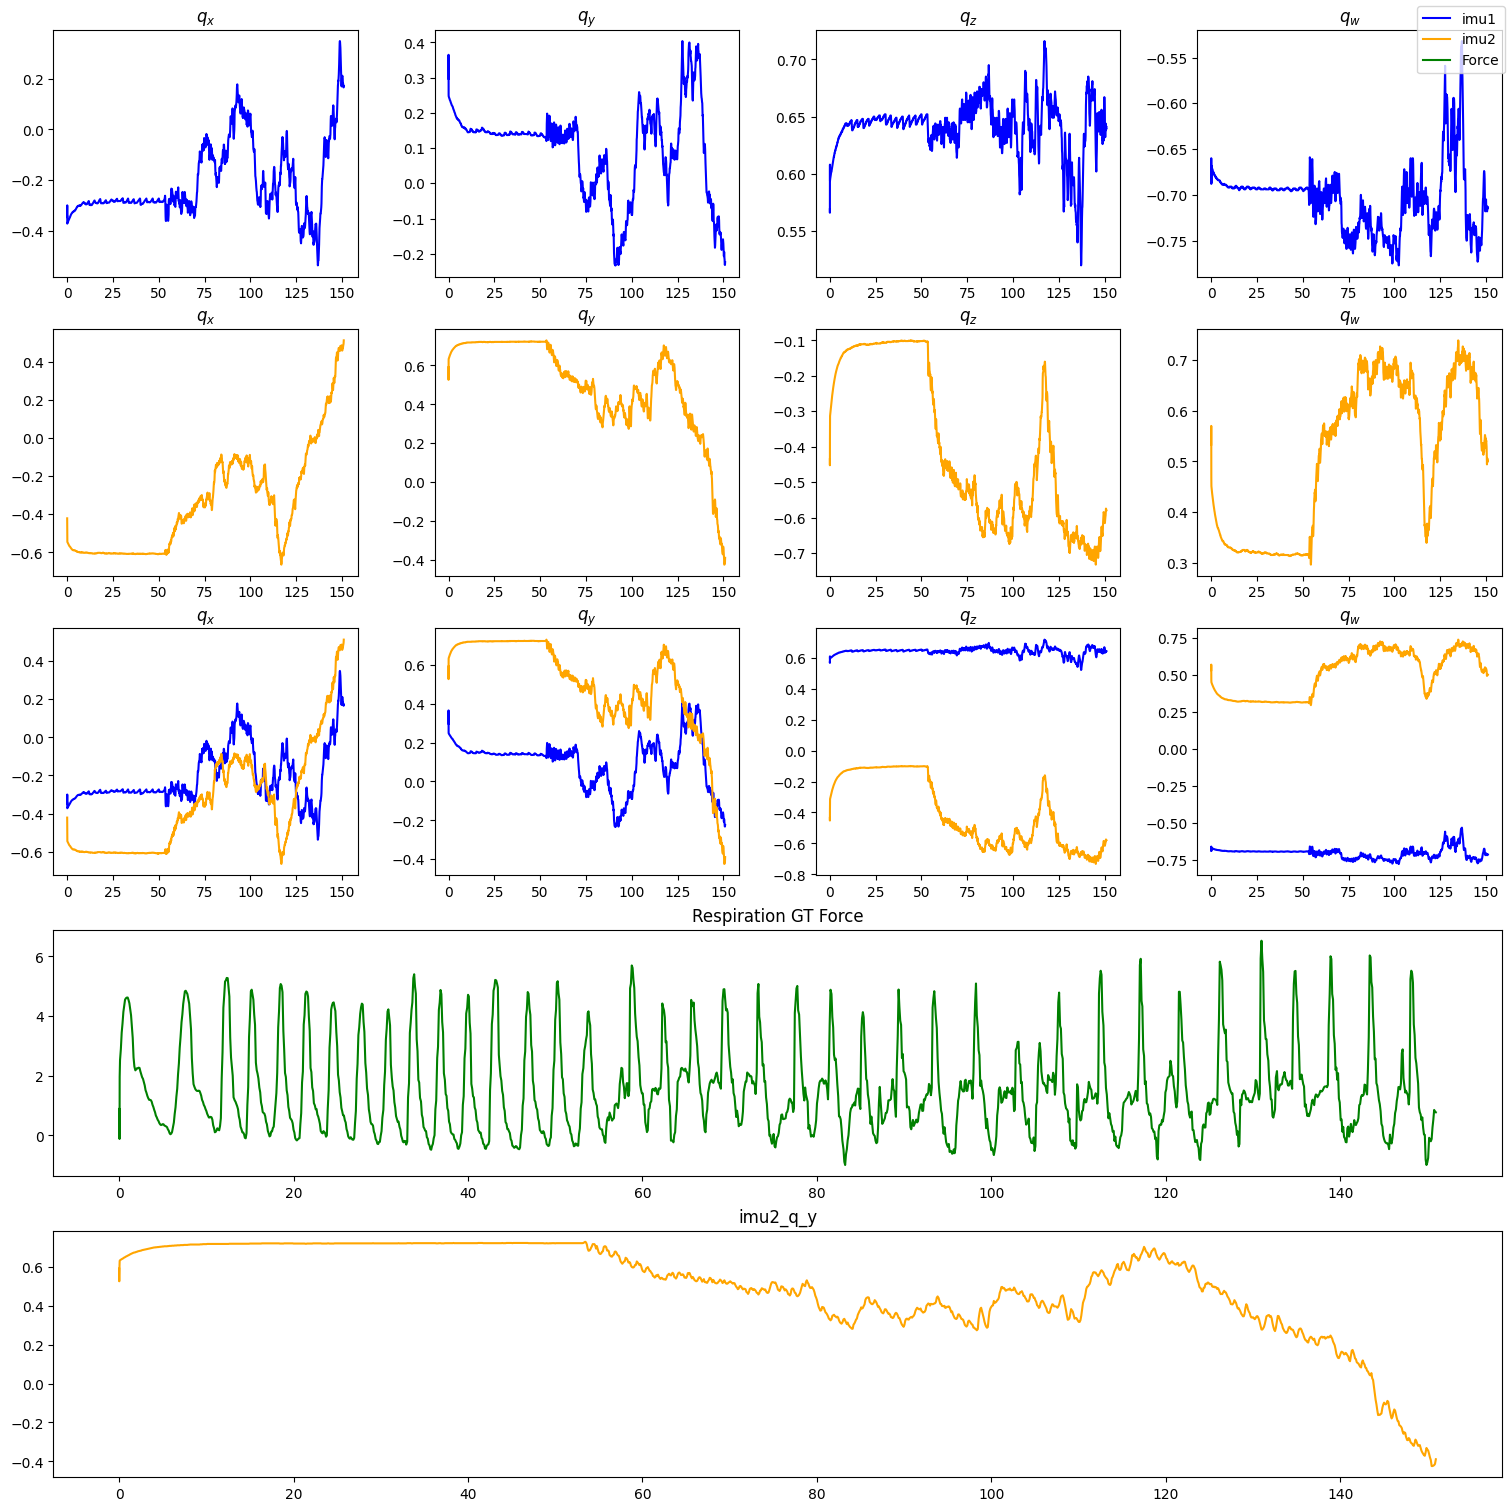

In [4]:
fs = 10
start_pt, end_pt = 0, -1
still_pt = 300 # 500

file_path = "./data/2_26/stand2walk_1.csv" 
# "./data/3_19/delay/stand2rotate_2.csv" 
# ./data/1_19/stand2run_1.csv, ./data/2_26/stand2wobbleLR_1.csv, ./data/3_6/wobbleLR_2.csv (delay)
# ./data/3_6/sit_2.csv, ./data/3_6/stand_1.csv, ./data/3_6/walk_stand_2.csv, ./data/3_6/wobbleLR_2.csv

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=True, show_gt=True)
# draw_imu_curve(data, overlap=True, show_gt=False)

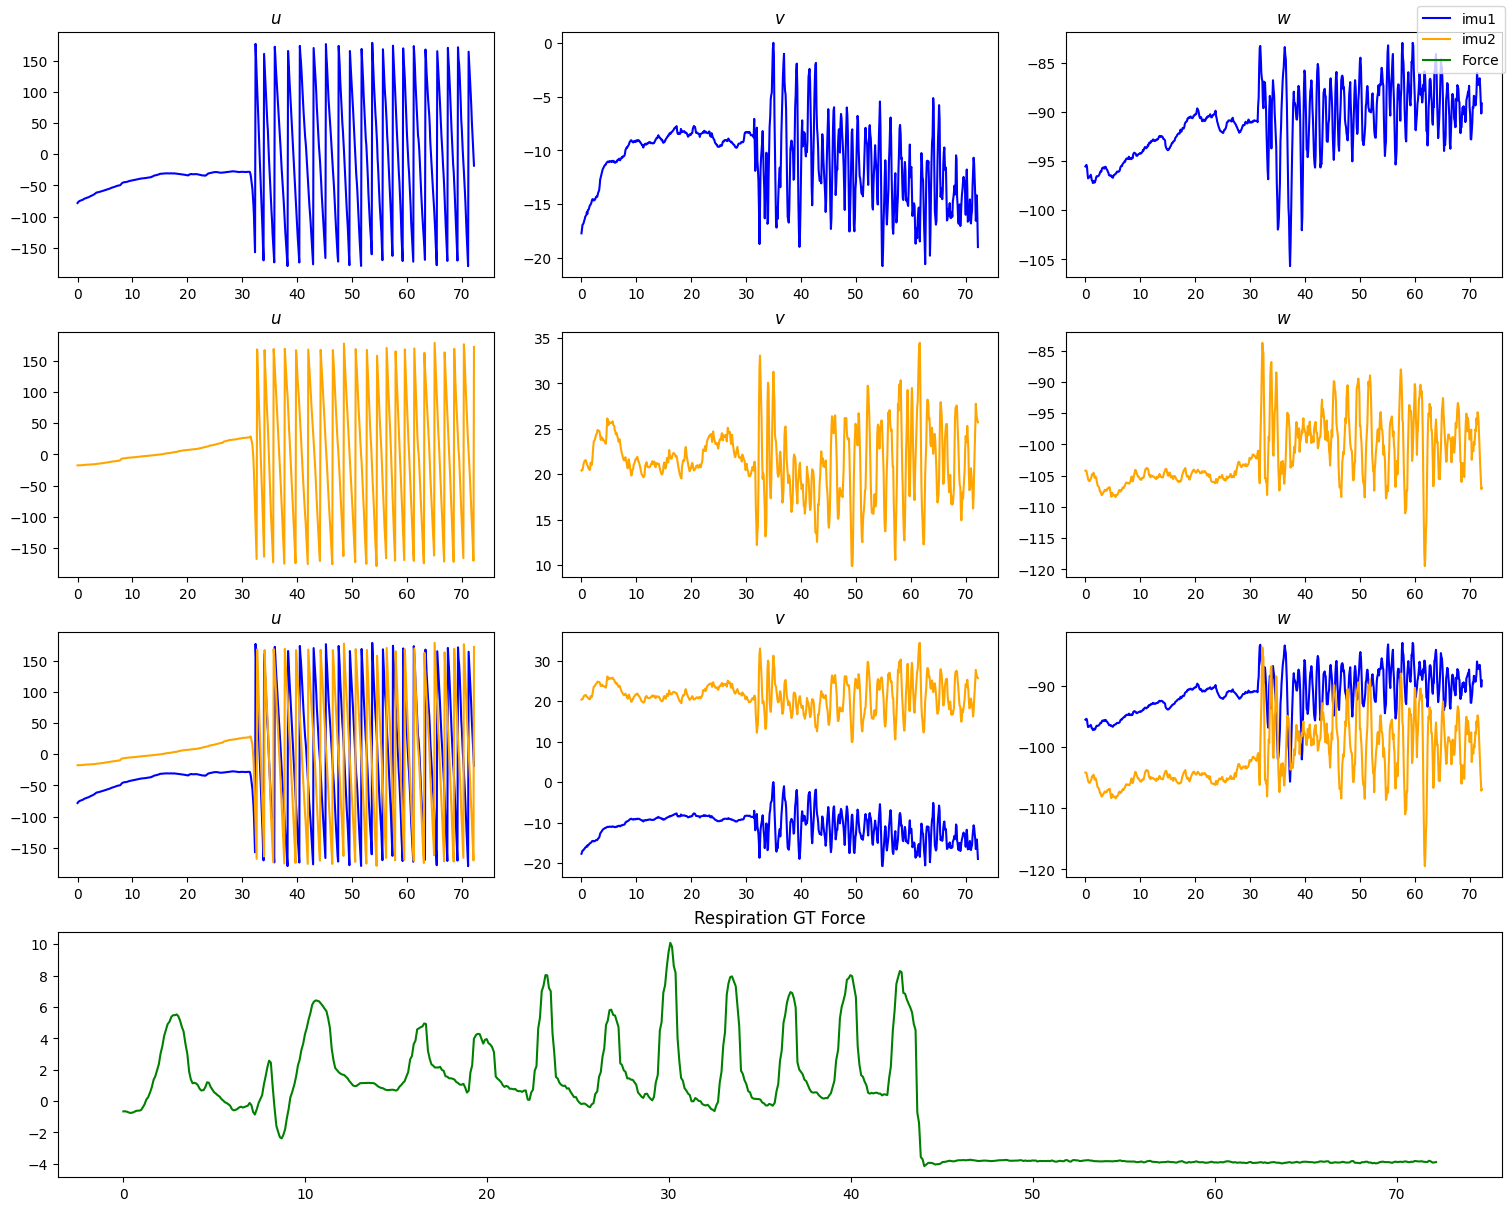

In [3]:
euler_axes = ['u', 'v', 'w']
euler_angles = {}
for imu in sensor_names:
    q = data[[imu + "_" + "q_x", imu + "_" + "q_y", imu + "_" + "q_z", imu + "_" + "q_w"]].values
    u, v, w = quaternion_to_euler(q)
    euler_angle = [u, v, w]
    # euler_angle = [u - np.mean(u), v - np.mean(v), w - np.mean(w)]
    for i, euler_axis in enumerate(euler_axes):
        euler_angles[imu + "_" + euler_axis] = euler_angle[i]

draw_imu_curve_euler(data, euler_angles, overlap=True, show_gt=True)
# draw_imu_curve_euler(data, euler_angles, overlap=True, show_gt=False)

In [97]:
q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)

best_score/total: 74/300


In [98]:
target, skew = 'imu1', 'imu2'
Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
data_aligned = data.copy()

for i, col in enumerate(cols):
    data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

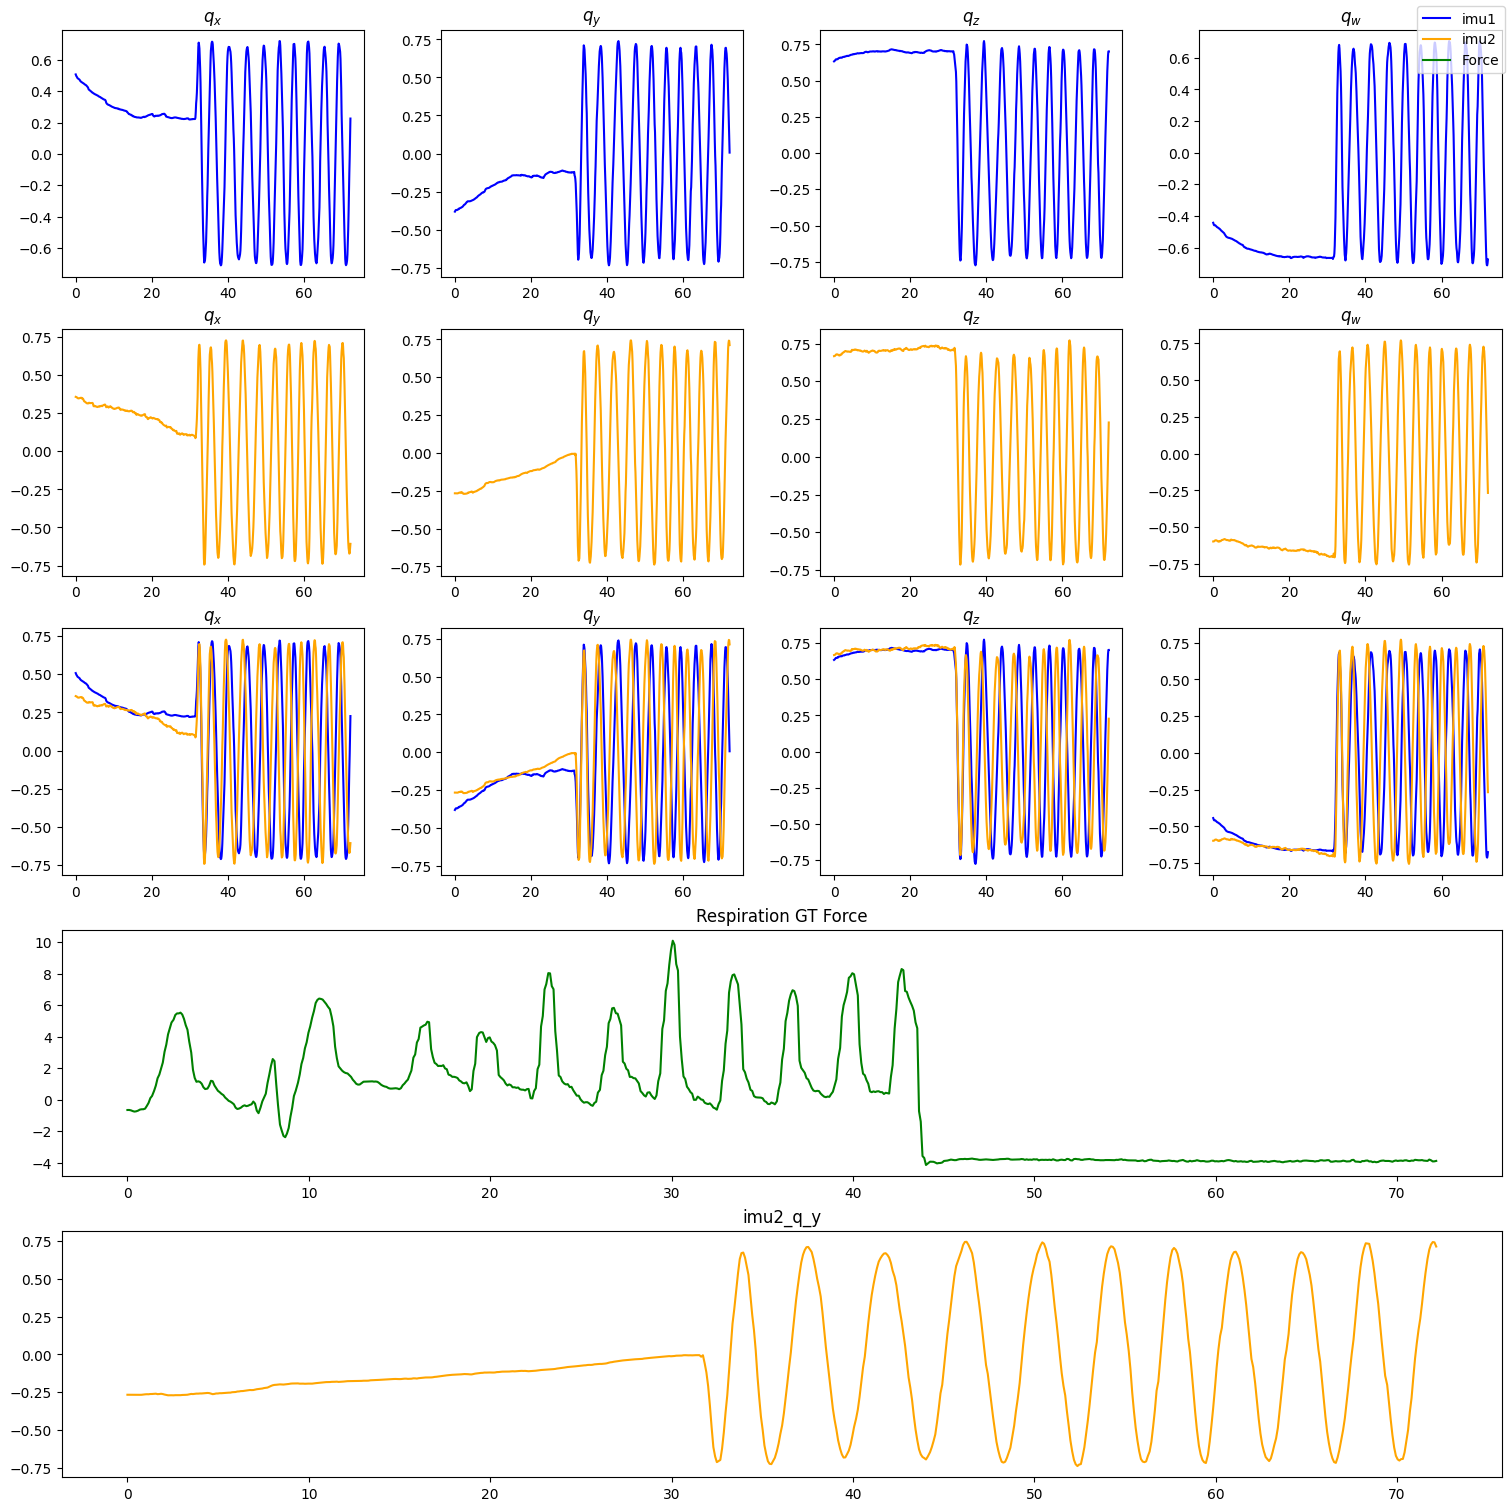

In [99]:
draw_imu_curve(data_aligned, overlap=True, show_gt=True)
# draw_imu_curve(data_aligned, overlap=True, show_gt=False)

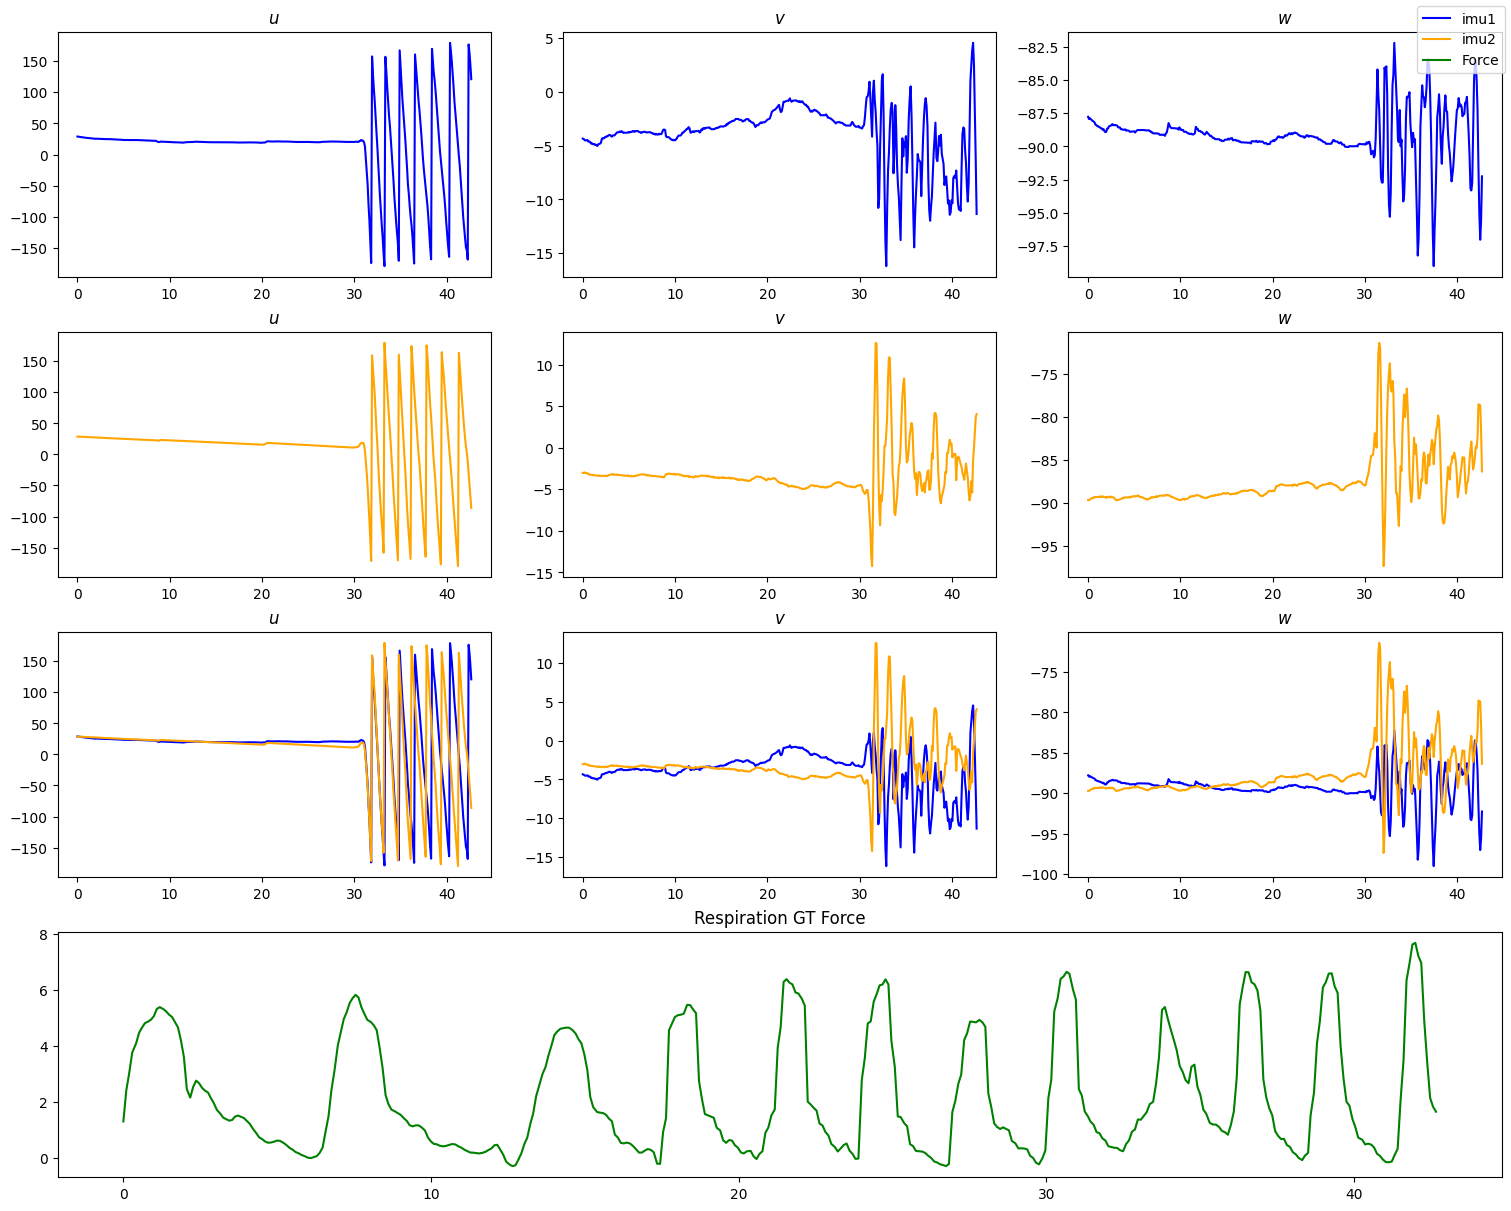

In [94]:
euler_axes = ['u', 'v', 'w']
euler_angles = {}
for imu in sensor_names:
    q = data_aligned[[imu + "_" + "q_x", imu + "_" + "q_y", imu + "_" + "q_z", imu + "_" + "q_w"]].values
    u, v, w = quaternion_to_euler(q)
    euler_angle = [u, v, w]
    # euler_angle = [u - np.mean(u), v - np.mean(v), w - np.mean(w)]
    for i, euler_axis in enumerate(euler_axes):
        euler_angles[imu + "_" + euler_axis] = euler_angle[i]
        data_aligned[imu + "_" + euler_axis] = euler_angle[i]

draw_imu_curve_euler(data_aligned, euler_angles, overlap=True, show_gt=True)
# draw_imu_curve_euler(data_aligned, euler_angles, overlap=True, show_gt=False)

In [88]:
data_aligned

,imu1_q_x,imu1_q_y,imu1_q_z,imu1_q_w,imu2_q_x,imu2_q_y,imu2_q_z,imu2_q_w,Force,RR,imu1_u,imu1_v,imu1_w,imu2_u,imu2_v,imu2_w
Timestamp,,,,,,,,,,,,,,,,
2025-03-19 08:58:33.967311,0.334,-0.367,-0.597,0.630,0.339656,-0.364370,-0.600942,0.625090,3.554710,NaN,59.447939,-3.649480,-89.002944,59.715060,-2.711198,-89.299822
2025-03-19 08:58:34.063609,0.335,-0.367,-0.598,0.630,0.339656,-0.364370,-0.600942,0.625090,3.805099,NaN,59.480076,-3.535821,-89.035081,59.715060,-2.711198,-89.299822
2025-03-19 08:58:34.175266,0.335,-0.367,-0.598,0.630,0.340235,-0.365173,-0.600694,0.624545,3.891968,NaN,59.480076,-3.535821,-89.035081,59.844890,-2.715662,-89.332779
2025-03-19 08:58:34.286565,0.335,-0.367,-0.597,0.629,0.339656,-0.364370,-0.600942,0.625090,3.953293,NaN,59.560584,-3.540840,-89.036383,59.715060,-2.711198,-89.299822
2025-03-19 08:58:34.383234,0.335,-0.367,-0.597,0.629,0.340235,-0.365173,-0.600694,0.624545,3.971176,NaN,59.560584,-3.540840,-89.036383,59.844890,-2.715662,-89.332779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-19 09:02:48.946891,0.093,-0.415,-0.573,0.700,0.260096,-0.463711,-0.538684,0.653560,3.460175,NaN,43.541013,-28.346356,-90.124118,62.629353,-19.020547,-90.631422
2025-03-19 09:02:49.042657,0.113,-0.475,-0.556,0.673,0.256233,-0.531391,-0.507687,0.627871,1.950172,NaN,52.412108,-30.894463,-94.614164,70.563525,-24.023932,-95.040298
2025-03-19 09:02:49.139046,0.108,-0.477,-0.537,0.687,0.297091,-0.516755,-0.508164,0.621668,-0.014626,NaN,51.734012,-32.660435,-92.197417,72.073228,-19.910928,-93.080881


# ANC

In [16]:
data_anc = data_aligned # data used in anc
data_anc = data_anc[still_pt+100:]
# cols = ['q_x', 'q_y', 'q_z', 'q_w'] # for quaternion
cols = ['u', 'v', 'w'] # for euler angle

data_anc["Force"] = butter_filter(data_anc["Force"])

C:\Users\user\AppData\Local\Temp\ipykernel_19844\2212500365.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_anc["Force"] = butter_filter(data_anc["Force"])


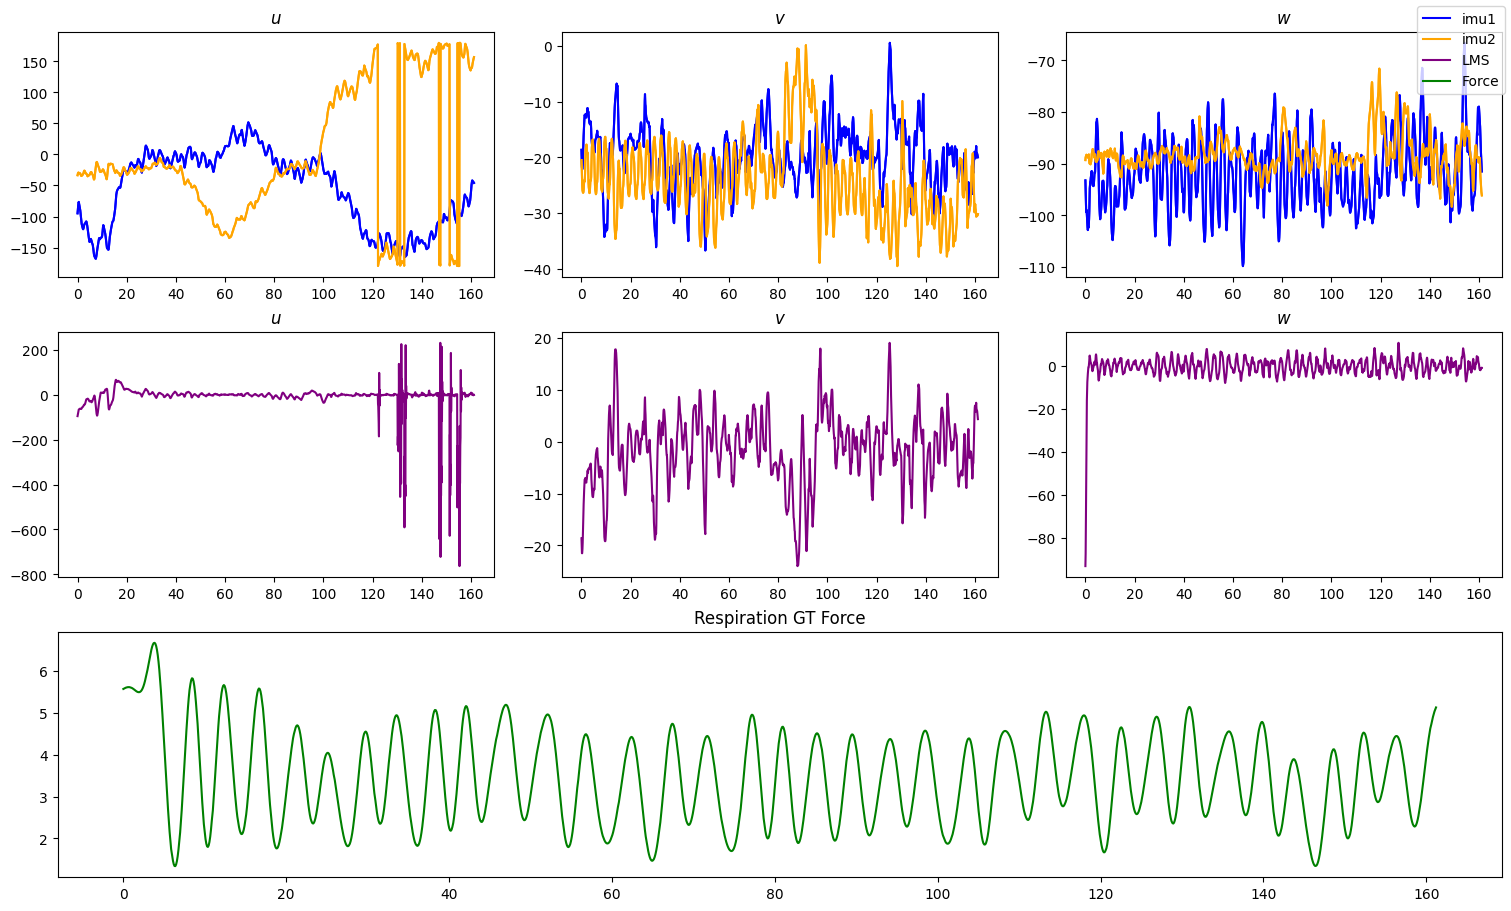

In [20]:
NTAPS = 5 # 10
LEARNING_RATE = 0.00001 # 0.001

outputs_dict_LMS = {}
outputs_dict_LMS['method'] = 'LMS'
coefficients_dict_LMS = {}
coefficients_dict_LMS['method'] = 'LMS'
for col in cols:
    d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
    x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        canceller = f.filter(ref_noise)
        output_signal = d[i] - canceller
        f.lms(output_signal, LEARNING_RATE)
        coefficients_history[i] = f.coefficients
        y[i] = output_signal
    
    outputs_dict_LMS[col] = y
    coefficients_dict_LMS[col] = coefficients_history

# print(outputs_dict_LMS)
draw_anc_curve_multi(data_anc, outputs=[outputs_dict_LMS], cols=cols)
# draw_fir_coefficients_curve(data_anc, coefficients=coefficients_dict_LMS)

LEARNING_RATE:-1.0901055395570292e-07
LEARNING_RATE:3.92133524113674e-05
LEARNING_RATE:3.3655394756528466e-05


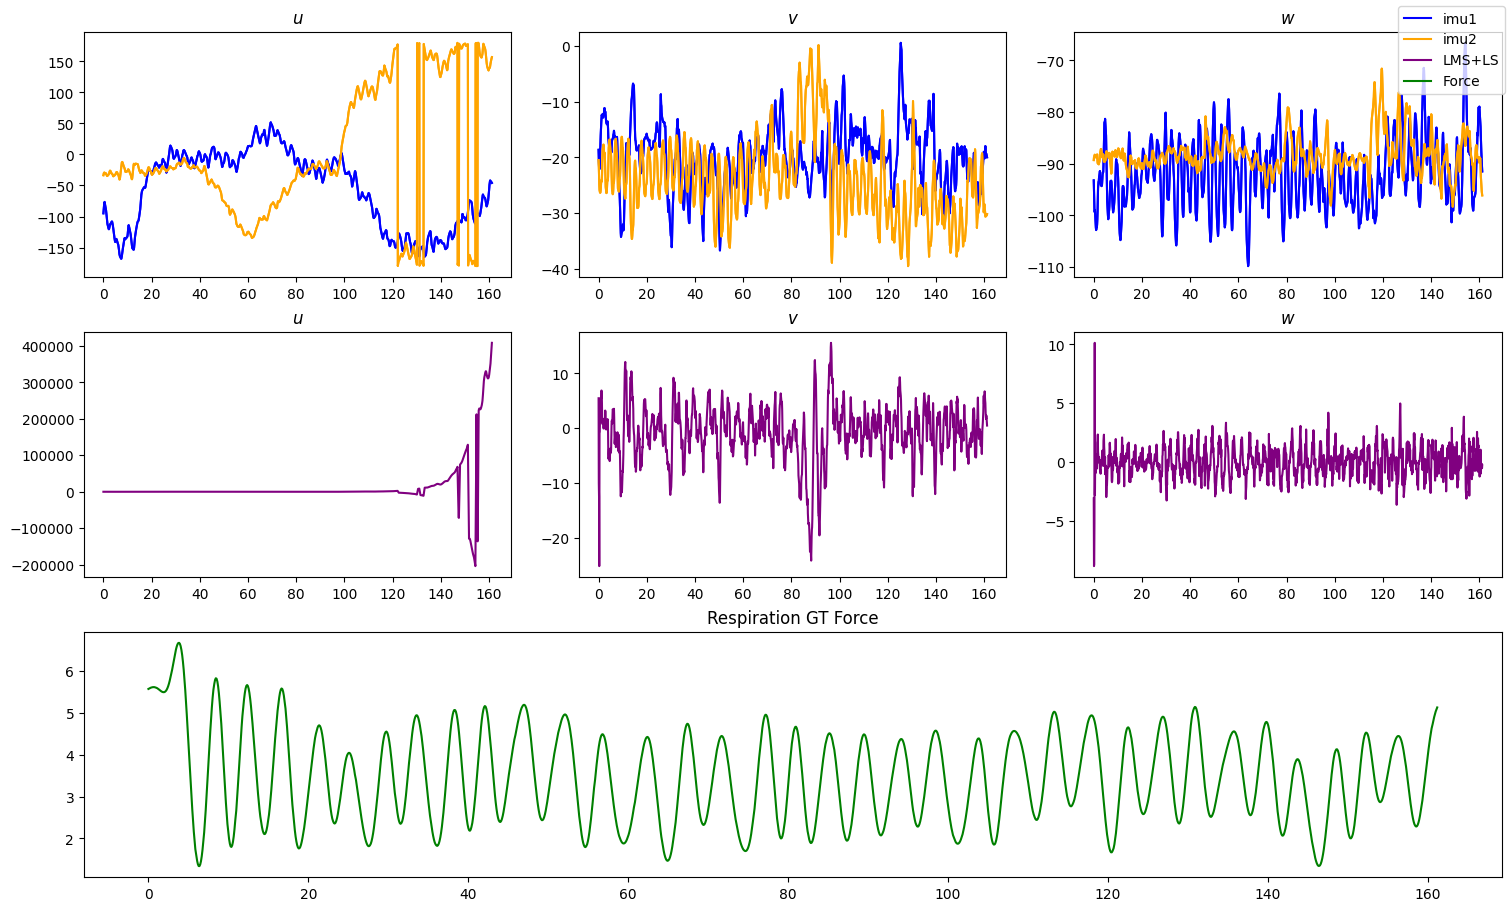

In [28]:
outputs_dict_LMSLS = {}
outputs_dict_LMSLS['method'] = 'LMS+LS'
coefficients_dict_LMSLS = {}
coefficients_dict_LMSLS['method'] = 'LMS+LS'
for col in cols:
    d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
    x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))

    # Least Square Once
    f.ls(x, d)
    LEARNING_RATE = np.max(f.coefficients) / (3*1e4) # / 100
    print(f'LEARNING_RATE:{LEARNING_RATE}')
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        canceller = f.filter(ref_noise)
        output_signal = d[i] - canceller
        f.lms(output_signal, LEARNING_RATE)
        coefficients_history[i] = f.coefficients
        y[i] = output_signal
    
    outputs_dict_LMSLS[col] = y
    coefficients_dict_LMSLS[col] = coefficients_history

draw_anc_curve_multi(data_anc, outputs=[outputs_dict_LMSLS], cols=cols)
# draw_fir_coefficients_curve(data_anc, coefficients=coefficients_dict_LMSLS)

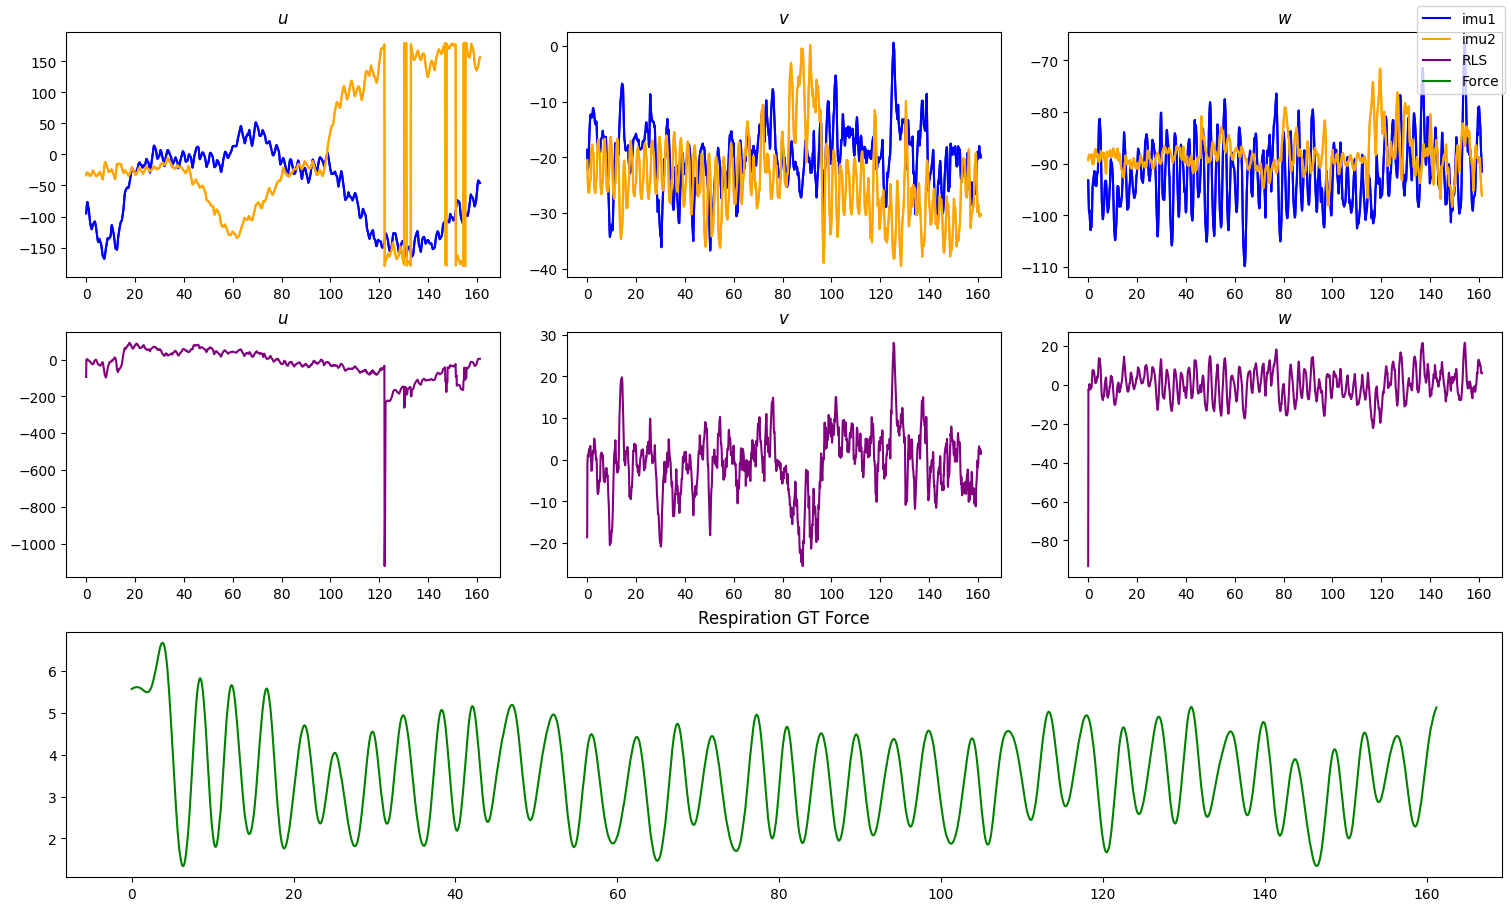

In [ ]:
outputs_dict_RLS = {}
outputs_dict_RLS['method'] = 'RLS'
coefficients_dict_RLS = {}
coefficients_dict_RLS['method'] = 'RLS'

# RLS
delta = 1 # 1
lam_rls = 0.998 # 0.9995, 0.998

for col in cols:
    d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
    x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        canceller = f.filter(ref_noise)
        output_signal = d[i] - canceller
        f.rls(output_signal, delta=delta, lam=lam_rls)
        coefficients_history[i] = f.coefficients
        y[i] = output_signal
    
    outputs_dict_RLS[col] = y
    coefficients_dict_RLS[col] = coefficients_history

draw_anc_curve_multi(data_anc, outputs=[outputs_dict_RLS], cols=cols)
# draw_fir_coefficients_curve(data_anc, coefficients=coefficients_dict_RLS)

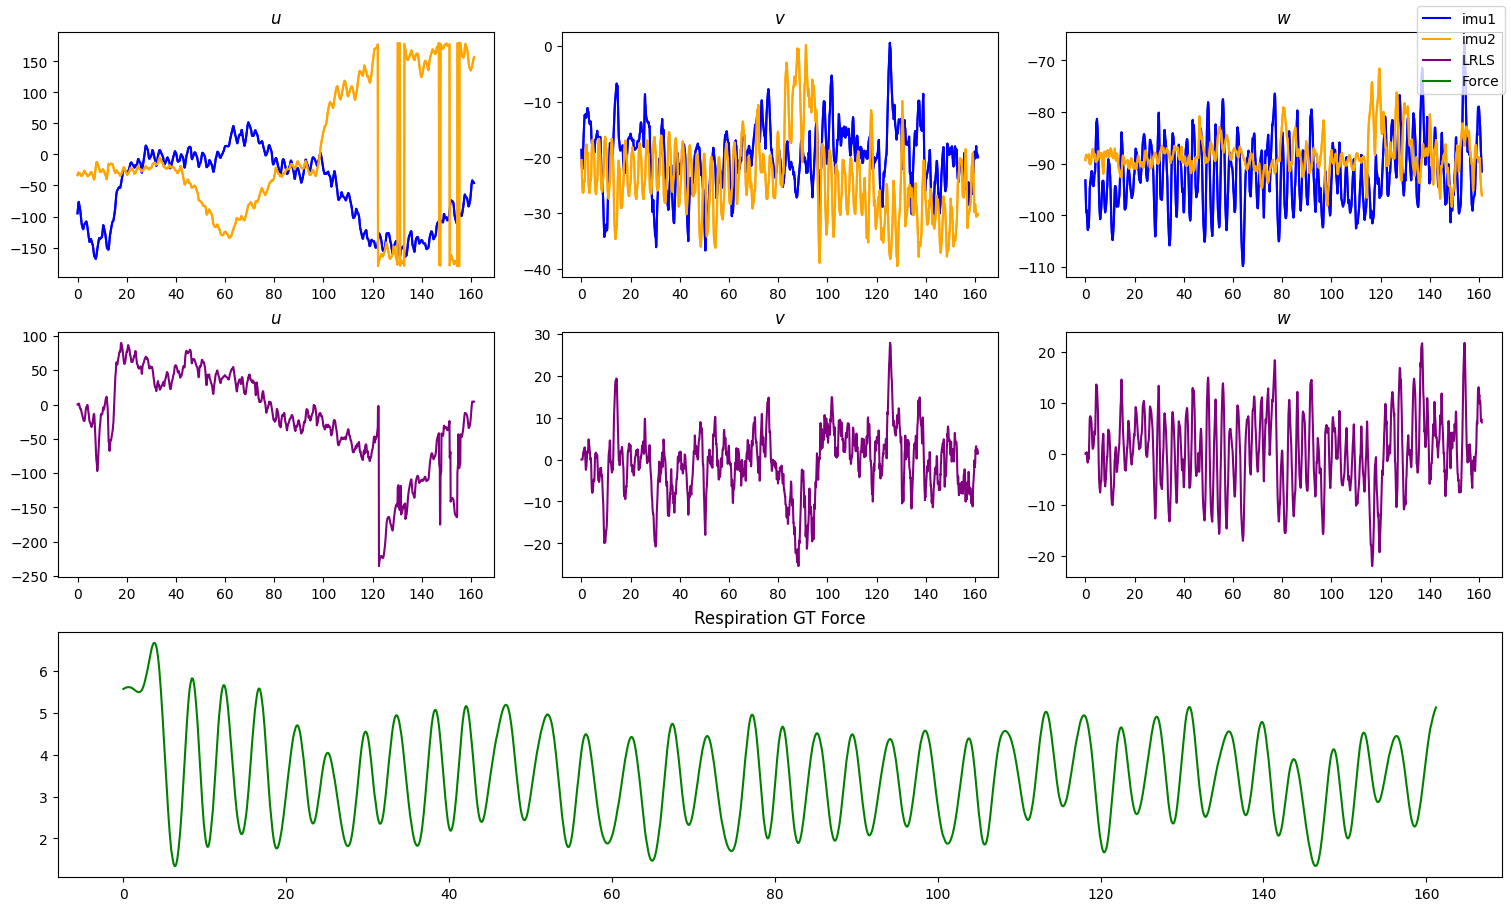

In [55]:
outputs_dict_LRLS = {}
outputs_dict_LRLS['method'] = 'LRLS'

# LRLS
epsilon = 1e-6
lam_lrls = 0.998 # 0.9995

for col in cols:
    d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
    x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        output_signal = f.lrls(x=ref_noise, d=d[i], N= len(d), lam=lam_lrls)
        y[i] = output_signal
    
    outputs_dict_LRLS[col] = y

draw_anc_curve_multi(data_anc, outputs=[outputs_dict_LRLS], cols=cols)

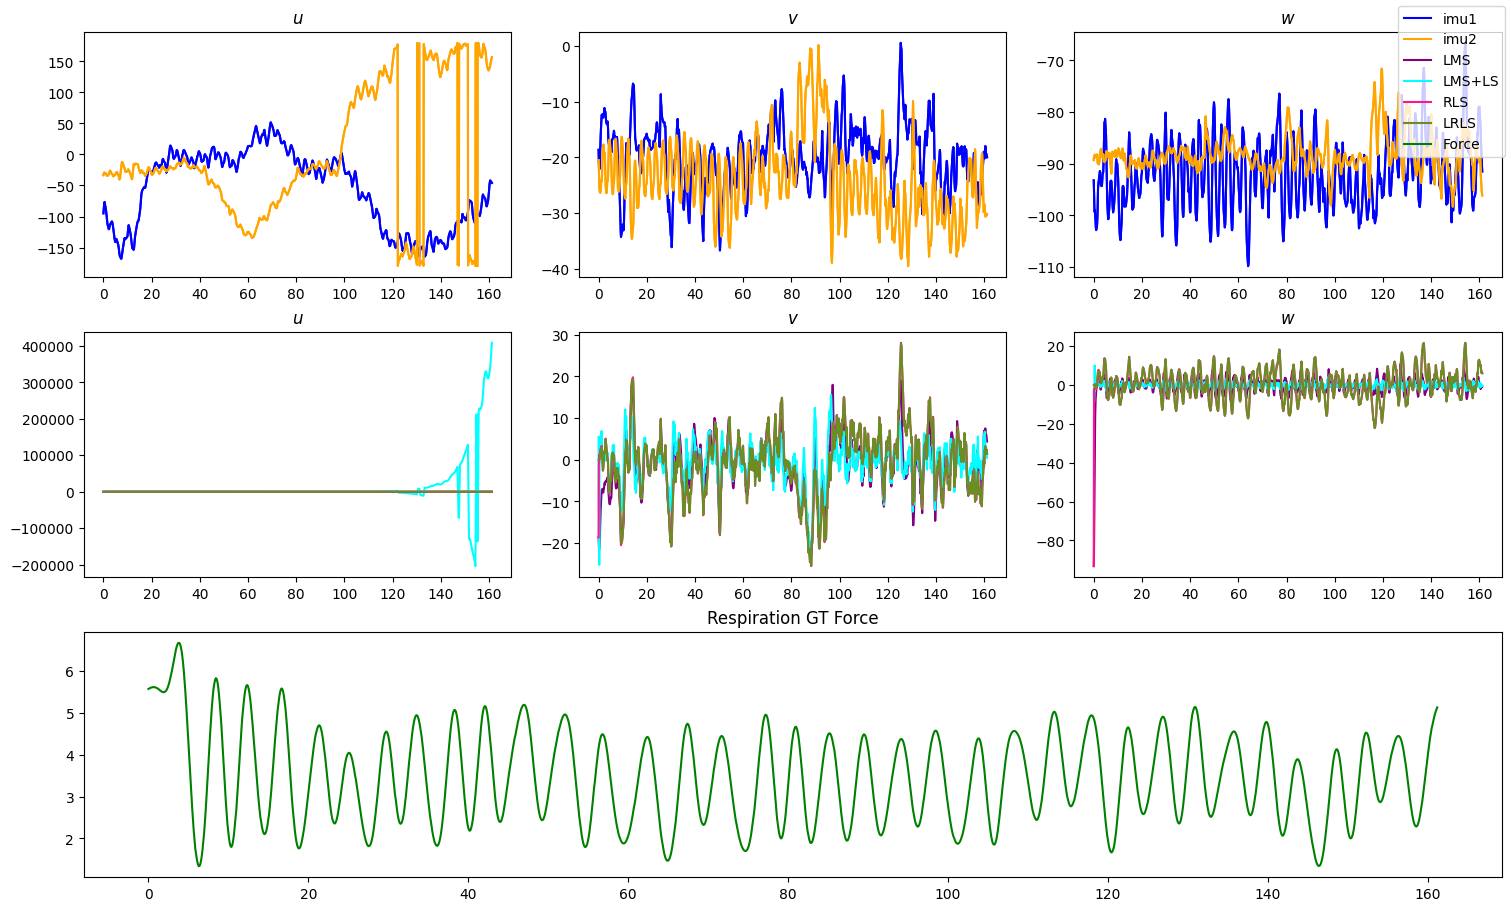

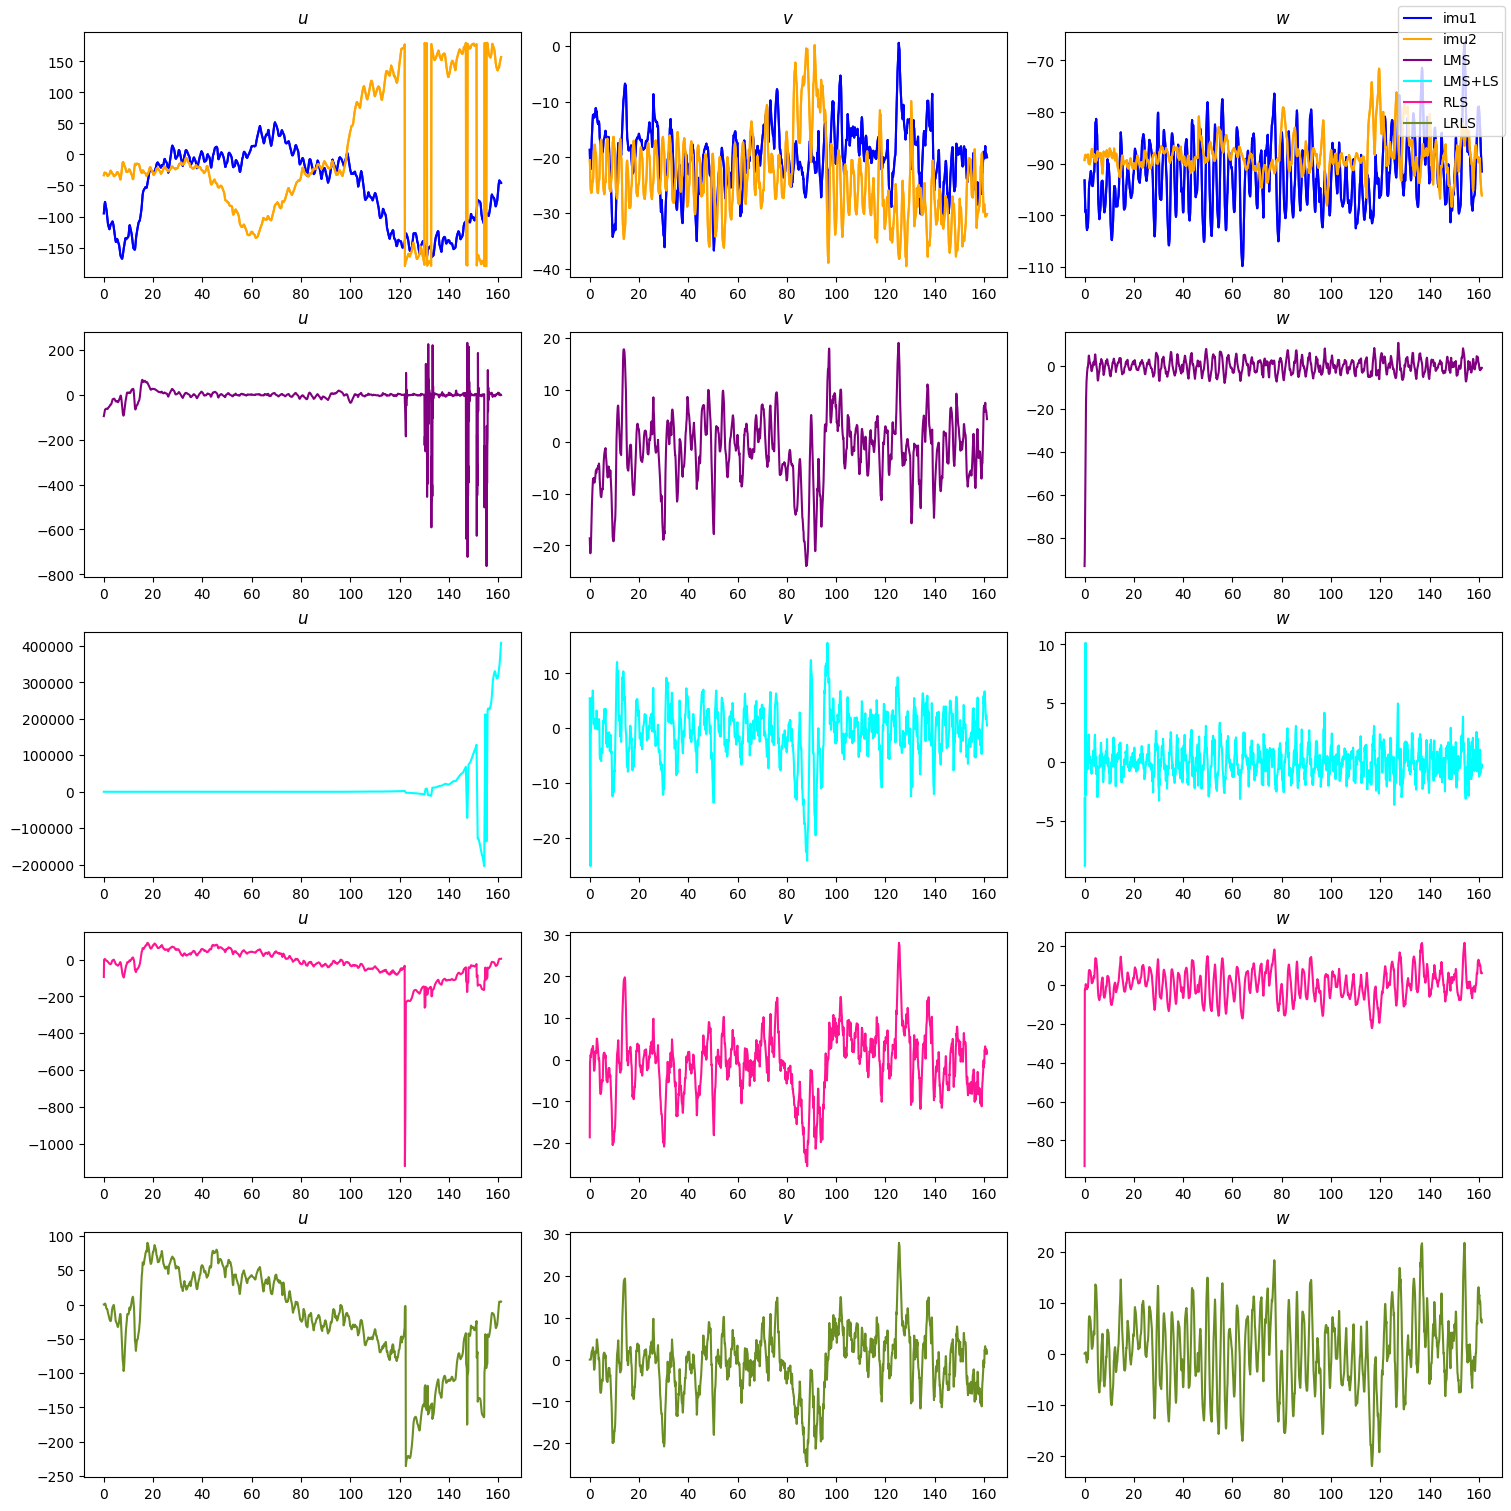

In [56]:
# Show all ANC results
draw_anc_curve_multi(data_anc, outputs=[outputs_dict_LMS, outputs_dict_LMSLS, outputs_dict_RLS, outputs_dict_LRLS], cols=cols)
draw_anc_curve_multi(data_anc, outputs=[outputs_dict_LMS, outputs_dict_LMSLS, outputs_dict_RLS, outputs_dict_LRLS], cols=cols, overlap=False, show_gt=False)

# Auto-Correlation

f_s :10, T:0.1, N:1649, n:100, t:164.9
window_num:78, overlap_size:80, window_size:100


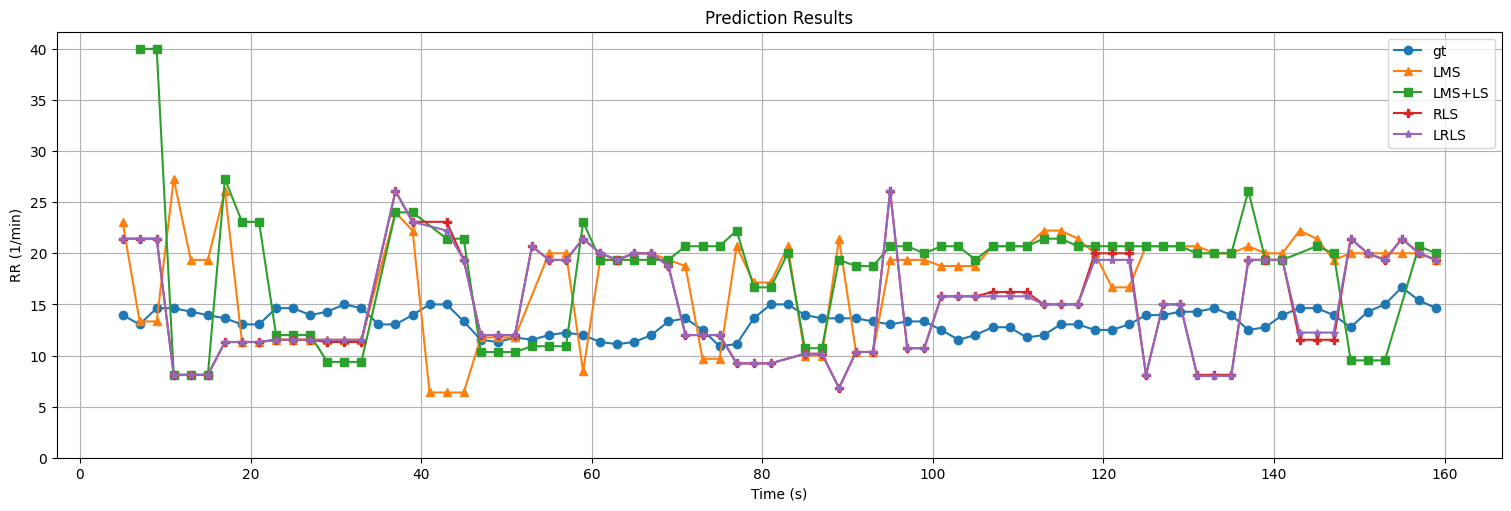

mae:{'LMS': 26.97914548044441, 'LMS+LS': 6.5319374571080475, 'RLS': 6.224141358285808, 'LRLS': 5.4203202537433}


In [60]:
window = 10
overlap = window - 2
mae = auto_correlation(data_anc, outputs=[outputs_dict_LMS, outputs_dict_LMSLS, outputs_dict_RLS, outputs_dict_LRLS], cols=cols,window=window, overlap=overlap, visualize=True)
print(f'mae:{mae}')